In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os
p_ = os.path.abspath(os.path.join('..', '00_utils'))
if p_ not in sys.path:
    sys.path.append(p_)
    
p_ = os.path.abspath(os.path.join('..', '00_models'))
if p_ not in sys.path:
    sys.path.append(p_)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

# pyomo
import importlib
import nn_pyomo_base

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d

### Data Generation

In [7]:
def generate_chebyshev_nodes(n, start, end):
    k = np.arange(n)
    x = np.cos(np.pi * k / (n - 1))
    nodes = 0.5 * (end - start) * x + 0.5 * (start + end)
    return np.sort(nodes)

In [8]:
def load_data(file_path, start_date, number_of_points):

    data = pd.read_csv(file_path)
    data_subsample = data[data.settlement_date >= start_date]
    # data_subsample = data_subsample[data_subsample.settlement_date < '2010-01-10']
    data_subsample = data_subsample[:number_of_points]
    data_subsample.reset_index(drop=True, inplace=True)

    data_subsample['settlement_date'] = pd.to_datetime(data_subsample['settlement_date'])
    data_subsample.loc[:,'hour'] = data_subsample['settlement_date'].dt.hour

    # select the main columns for the intial testing
    data_subsample = data_subsample[['settlement_date', 'temperature', 'hour', 'nd']]

    print(f"The first/ last time points in the subsample are {np.min(data_subsample.settlement_date)}/ {np.max(data_subsample.settlement_date)}")
    print(f"Covering {np.max(data_subsample['settlement_date'].dt.day) - np.min(data_subsample['settlement_date'].dt.day)} days")

    t = jnp.linspace(0., 1., data_subsample.shape[0]) 

    # How many points cover one day?   
    one_day_map = (data_subsample['settlement_date'].dt.day == np.min(data_subsample['settlement_date'].dt.day))
    n_pt_per_day = one_day_map.sum()
    print(f"Number of points per day: {n_pt_per_day}")

    one_day_offset = (1/data_subsample.shape[0]) * n_pt_per_day
    print(f"Time offset needed for 1 day: {one_day_offset}")

    data_subsample.rename(columns={'settlement_date': 'date', 'temperature': 'var1', 'hour':'var2', 'nd':'y'}, inplace=True)
    data_subsample['t'] = t
    
    return data_subsample

In [9]:
def preprocessing(data_subsample, tau, m, sigma = 1, split = 300, num_nodes_mult = 1, equally_spaced = False):
    """
    Args:
        data_subsample (dataframe): dataframe containing the subsample of the data;
        expected column names are: 'y', 'date', 'var1', 'var2' ect.
        tau (float): number of points per lag
        m (int): number of lags
    """
    d = data_subsample.copy()   
    columns = data_subsample.columns
    if 't' not in columns:
        raise ValueError("The time column is not present in the dataframe")
    if 'y' not in columns:
        raise ValueError("The target column is not present in the dataframe")
    
    t, y = data_subsample['t'], data_subsample['y']
    
    #----------------------------- SMOOTHING -----------------------------#
    y = gaussian_filter1d(y, sigma = sigma)
    d['y'] = y
    
    #--------------------------------- LAGS -----------------------------#
    for i in range(1, m+1):
        d[f'y_lag{i}'] = d['y'].shift(tau*i)
            
    # the first point that has the last lag available
    first_index = d[f'y_lag{i}'].index[~d[f'y_lag{i}'].isna()][0]

    # drop rows where time lags are not available
    # subtract the first index from the split point 
    split -= first_index
    d = d.iloc[first_index:]
    t = d['t'] 
    
    ##### --------------------------------------------------------------------------------------------------TRAIN TEST SPLIT RATIO #####
    #split = int(0.75 * len(t)) 
    t_train, t_test = t[:split], t[split:]

    print(f"Training data: {t_train.shape[0]} timepoints")
    print(f"Training data: {t_test.shape[0]} timepoints")

    ##### ----------------------------------------------------------------------------------------------TRAIN DATA SIZE MULTIPLIES #####
    # -------------------- CHEBYSHEV NODES FOR THE TRAIN DATA --------------------- #
    if equally_spaced:
        num_nodes = len(t_train)*num_nodes_mult
        t_train = generate_chebyshev_nodes(num_nodes, t_train.min(), t_train.max())
    else:
        num_nodes = len(t_train)*num_nodes_mult
        t_train = np.linspace(t_train.min(), t_train.max(), num_nodes)
    
    # ------------------------- INTERPOLATION FUNCTIONS --------------------------- #

    var_cols_map = ['var' in col for col in d.columns]
    var_cols = d.columns[var_cols_map]
    
    # 1. fit interpolation functions 
    # 2. geneate data
    # 3. save to a new dataframe
    
    interpolated_data_train = {}
    interpolated_data_test = {}
    
    # INDEPENDENT VARIABLES
    for var in var_cols:
        cs = CubicSpline(t, d[var])
        interpolated_data_train[var] = cs(t_train)
        interpolated_data_test[var] = cs(t_test)
        
    # DEPENDENT VARIABLES    
    cs_y = CubicSpline(t, d['y'])
    interpolated_data_train['y'] = cs_y(t_train)
    interpolated_data_test['y'] = cs_y(t_test)
    
    # LAGGED DEPENDENT VARIABLES
    for i in range(1, m+1):
        cs = CubicSpline(t, d[f'y_lag{i}'])
        interpolated_data_train[f'y_lag{i}'] = cs(t_train)
        # here we need some logic to reuse the data available from the training set
        interpolated_data_test[f'y_lag{i}'] = cs(t_test)
        # this gives the whole range, but we need to cut it off where the training data ends
        offset = tau*i # points are needed for the lag
        for p in range(offset, len(t_test)):
            interpolated_data_test[f'y_lag{i}'][p] = np.nan
        
    # TIME
    interpolated_data_train['t'] = t_train
    interpolated_data_test['t'] = t_test

    print(f"Training data: {t_train.shape[0]} timepoints after interpolation")
    
    df_train = pd.DataFrame(interpolated_data_train)
    df_test = pd.DataFrame(interpolated_data_test)

    #------------------------- SCALE ---------------------------#
    scaler = StandardScaler()
    
    columns_to_scale = df_train.columns.difference(['t'])
    df_train[columns_to_scale] = scaler.fit_transform(df_train[columns_to_scale])
    df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])
    
    return df_train, df_test

In [10]:
file_path = 'df_train.csv'
start_date = '2010-01-10'
number_of_points = 400

data_subsample = load_data(file_path, start_date, number_of_points)
df_train, df_test = preprocessing(data_subsample, 48, 2)

The first/ last time points in the subsample are 2010-01-10 00:00:00/ 2010-01-18 07:30:00
Covering 8 days
Number of points per day: 48
Time offset needed for 1 day: 0.12
Training data: 204 timepoints
Training data: 100 timepoints
Training data: 204 timepoints after interpolation


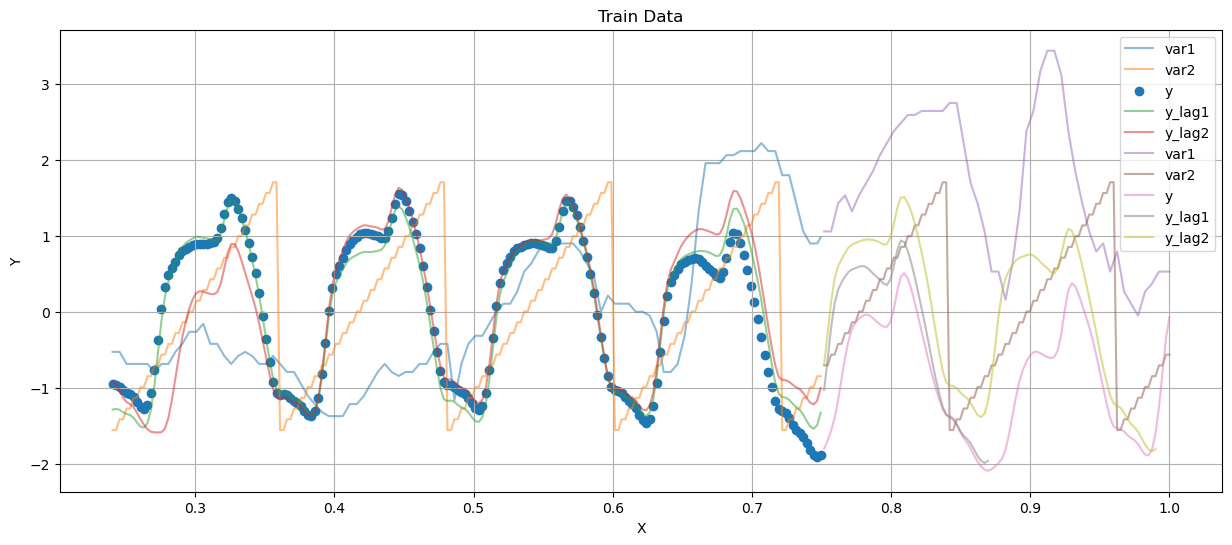

In [11]:
if True:
    plt.figure(figsize=(15, 6))
    for col in df_train.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train['t'], df_train[col], label=col, alpha=1)
            continue
        plt.plot(df_train['t'], df_train[col], '-', label=col, alpha=0.5)
        
    for col in df_test.columns.difference(['t']):
        plt.plot(df_test['t'], df_test[col], '-', label=col, alpha=0.5)
    #plt.plot(t_train, y_train_scaled, '-', label='X_train_scaled', alpha=0.5)
    #plt.plot(x_train_cheb_lags, Xs[:,:2], 'b-', label='Dependent Variables', alpha=0.4, ls = '--')

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()

In [12]:
ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

In [13]:
weights = compute_weights(ts)
Ds = np.array(lagrange_derivative(ts, weights))

In [14]:
for i in range(1, 25, 5):
    start_date = f'2010-01-{i:02d}'
    print(start_date)

2010-01-01
2010-01-06
2010-01-11
2010-01-16
2010-01-21


In [20]:
import nn_pyomo_base
importlib.reload(nn_pyomo_base)
NeuralODEPyomo = nn_pyomo_base.NeuralODEPyomo

# solver.options['print_level'] = 5
tol = 1e-6
params = {"tol":1e-6, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        
        # repeat the same for the acceptable tolerances
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        
        "halt_on_ampl_error" : 'yes', "print_level": 5, 
        #"hessian_approximation": 'limited-memory', 
        #"mu_strategy": 'adaptive', #"check_derivatives_for_naninf": 'yes',
        #'nlp_scaling_method' = 'gradient-based', # 'linear_solver'] = 'ma57',
        "max_iter": 1000}


for i in range(10, 11):
    
    # DEFINE PARAMETERS FOR THE CURRENT ITERATION
    file_path = 'df_train.csv'
    start_date = f'2015-01-{i:02d}'
    number_of_points = 800
    lags_n = 2
    offset_tau = 48
    
    data_subsample = load_data(file_path, start_date, number_of_points)
    df_train, df_test = preprocessing(data_subsample, offset_tau, lags_n, sigma = 1, split = 300, num_nodes_mult = 1, equally_spaced = True)

    layer_widths = [5, 64, 1]

    ys = np.atleast_2d(df_train['y']).T
    ts = np.array(df_train['t'])
    Xs = np.array(df_train.drop(columns=['y', 't']))
    
    if len(ts) != len(Ds):
        weights = compute_weights(ts)
        Ds = np.array(lagrange_derivative(ts, weights))
    
    # INITIALIZE THE VARIABLES TO STORE THE RESULTS
    solver_time = 0
    mae_train, mae_test = 0, 0
    
    # ----------------------------------------------------------- #
    ode_model = NeuralODEPyomo(np.array(ys), # y
                            np.array(ts), # t
                            np.array(Ds),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = ys, 
                            penalty_lambda_reg = 0.01, 
                            time_invariant = True,
                            extra_input = Xs, # X
                            w_init_method = 'xavier', 
                            params = params,
                            #deriv_method="collocation",
                            penalty_lambda_smooth = 0.01,
                            #ncp = 3
                            #discretization_scheme = "LAGRANGE-RADAU",
                            )

    ode_model.build_model()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T

    y0 = ys[0]
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

    # print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
    # print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

The first/ last time points in the subsample are 2015-01-10 00:00:00/ 2015-01-26 15:30:00
Covering 16 days
Number of points per day: 48
Time offset needed for 1 day: 0.06
Training data: 204 timepoints
Training data: 500 timepoints
Training data: 204 timepoints after interpolation


TypeError: __init__() got an unexpected keyword argument 'penalty_lambda_smooth'

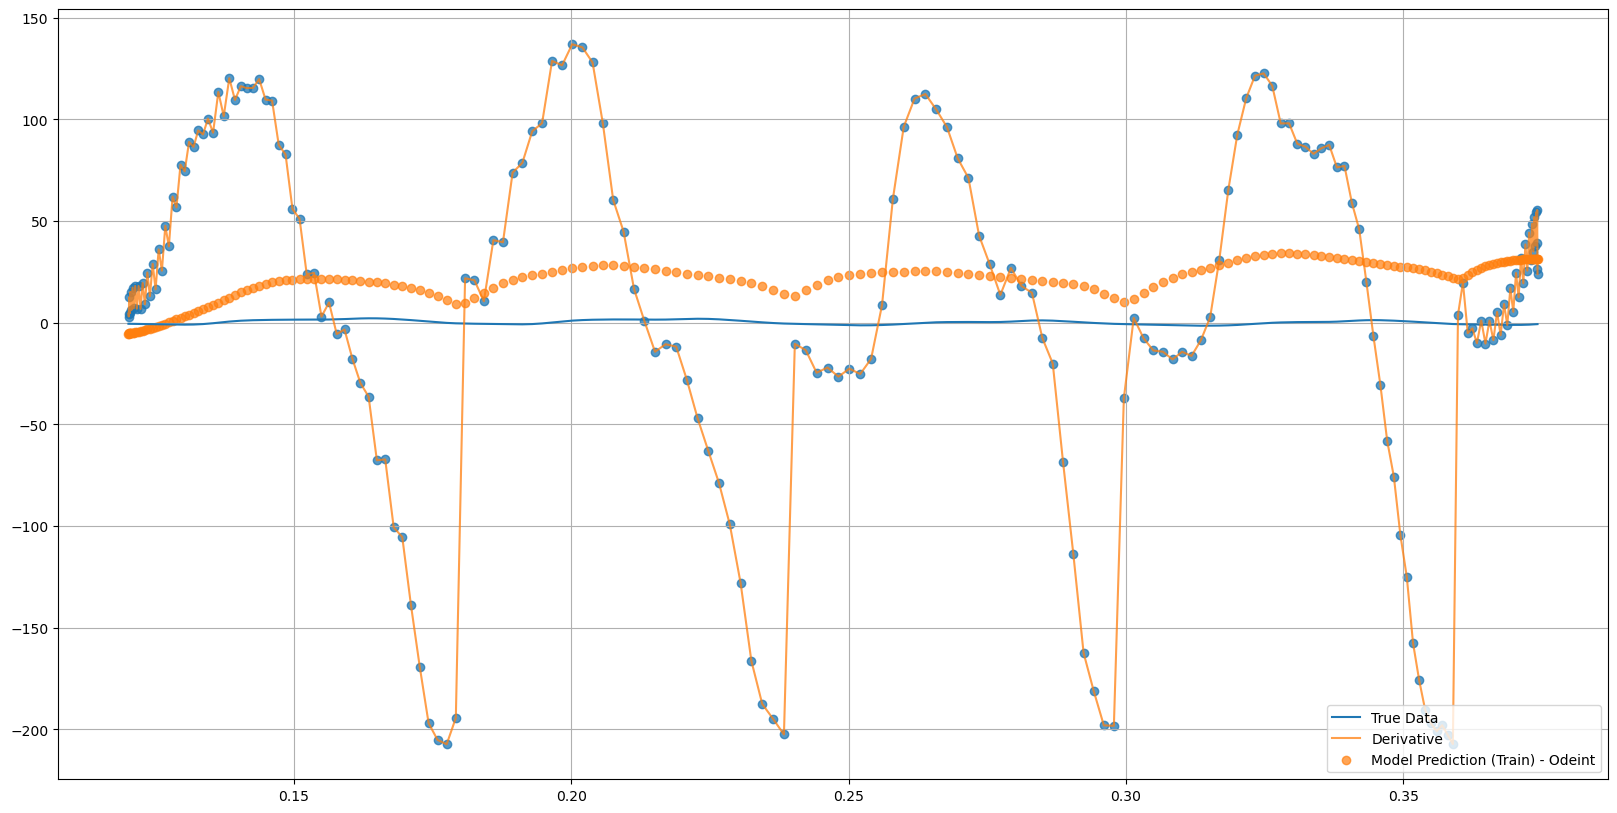

In [ ]:
len(ode_model.extract_derivative())

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts[1:], ode_model.extract_derivative()[1:], label='Derivative', alpha = 0.75)
plt.scatter(ts[1:], ode_model.extract_derivative()[1:], alpha = 0.75)
plt.scatter(ts, y_pred*10, label='Model Prediction (Train) - Odeint', alpha = 0.7)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1012
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      203

Total number of variables............................:      406
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
 

{'solver_time': 0.08951616287231445, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
203


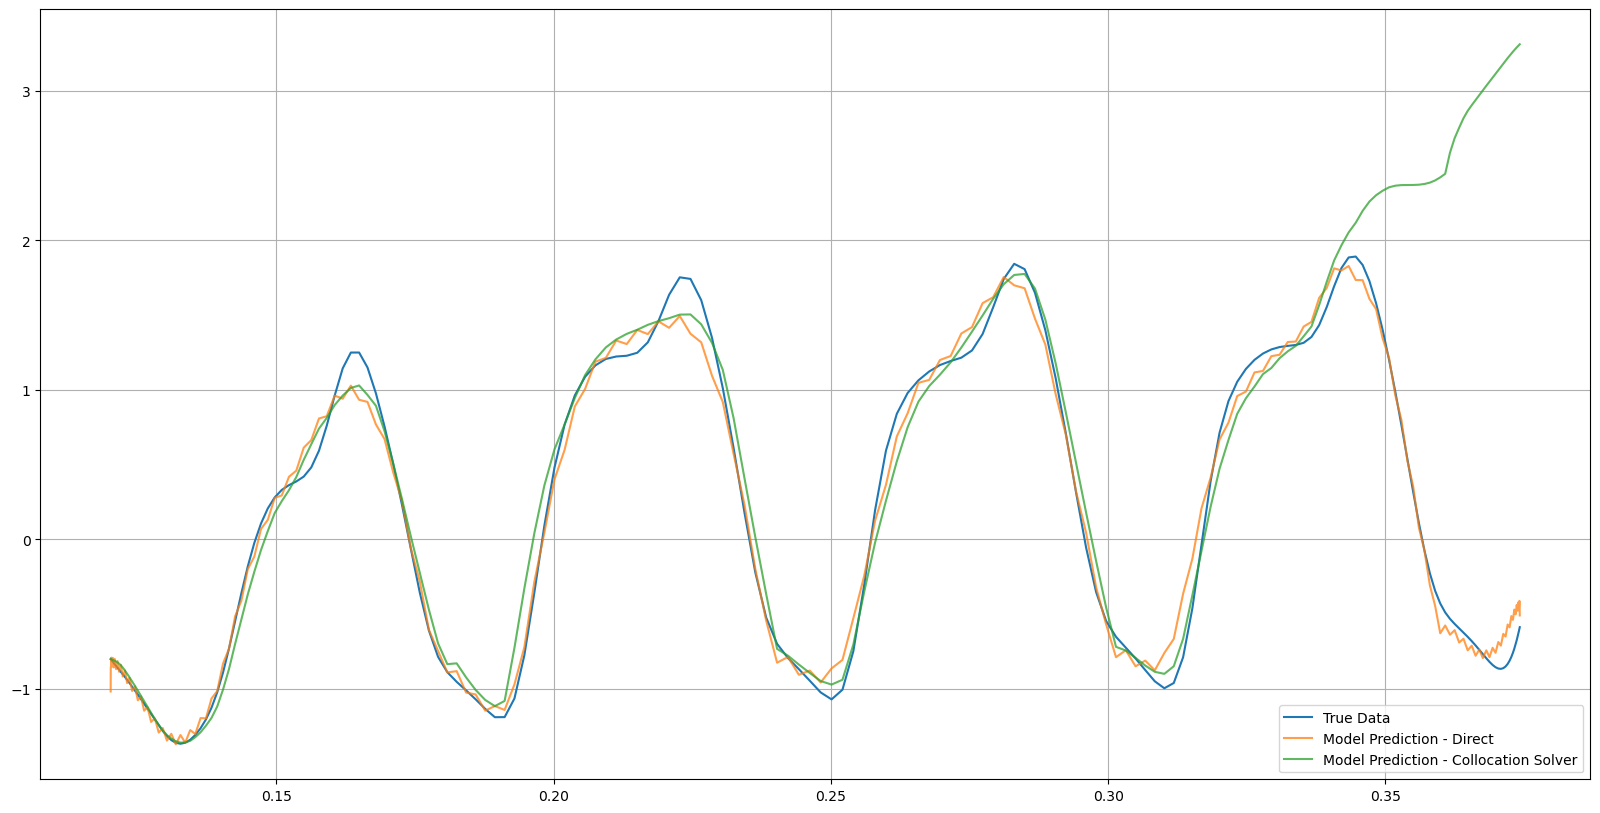

In [456]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state = (ys[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts)[1:], layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), 
                                params=params,
                                #discretization_scheme = "LAGRANGE-LEGENDRE"
                                )
# LAGRANGE-LEGENDRE

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)
#plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()


---

In [372]:
trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-8, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 100 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), 
                                #params=params,
                                #discretization_scheme = "LAGRANGE-LEGENDRE"
                                )
# LAGRANGE-LEGENDRE

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     9137
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1016

Total number of variables............................:     2032
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2031
Total number

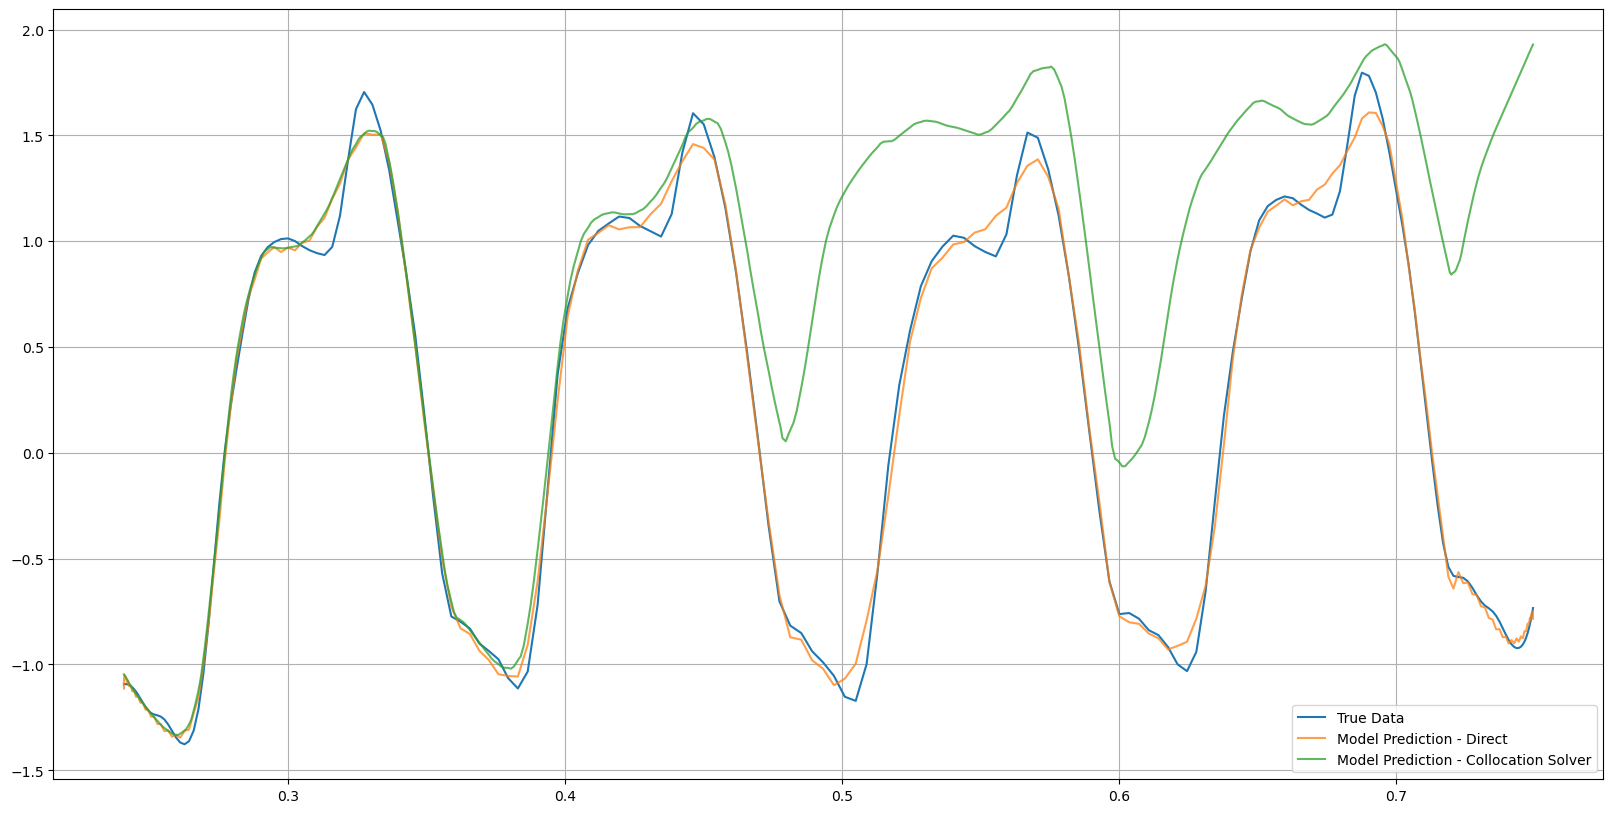

In [373]:
plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----
----

In [343]:
layer_widths = [5, 70, 1]

ys = np.atleast_2d(df_train['y']).T
ts = np.array(df_train['t'])
Xs = np.array(df_train.drop(columns=['y', 't']))

import nn_pyomo
importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
# ----------------------------------------------------------- #

# solver.options['print_level'] = 5
tol = 1e-5
params = {"tol":1e-5, 
          "dual_inf_tol": tol, 
          "compl_inf_tol": tol,
          "constr_viol_tol": tol, 
          
          # repeat the same for the acceptable tolerances
          "acceptable_tol": 1e-15,
          "acceptable_constr_viol_tol": 1e-15,
          "acceptable_dual_inf_tol": 1e-15,
          "acceptable_compl_inf_tol": 1e-15,
          "acceptable_iter": 0, 
          
          "halt_on_ampl_error" : 'yes',
          "print_level": 1, 
          #"hessian_approximation": 'limited-memory', 
          #"mu_strategy": 'adaptive', 
          #"check_derivatives_for_naninf": 'yes',
          #'nlp_scaling_method' = 'gradient-based',
          # 'linear_solver'] = 'ma57',
          "max_iter": 1000}

y0 = ys[0]
solver_time = 0
mae_train_direct, mae_train_ode, mae_train_coll = 0, 0, 0
for i in range(10):
    NeuralODEPyomo = nn_pyomo.NeuralODEPyomo
    ode_model = NeuralODEPyomo(np.array(ys), # y
                            np.array(ts), # t
                            np.array(Ds),
                            
                            layer_widths, act_func = "tanh", 
                            y_init = ys, 
                            penalty_lambda_reg = 0.001, 
                            time_invariant = True,
                            extra_input = Xs, # X
                            w_init_method = 'xavier', 
                            params = params,
                            deriv_method="collocation"
                            #discretization_scheme = "LAGRANGE-RADAU",
                            )

    ode_model.build_model()
    result = ode_model.solve_model()
    u_model = ode_model.extract_solution().T
    y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

    print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
    print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")
    solver_time += result['solver_time']
    
    mae_train_direct += np.mean(np.abs(ys.T - u_model))
    mae_train_ode += np.mean(np.abs(ys - y_pred))

    collocation_solver = False
    if collocation_solver:
        trained_weights_biases = ode_model.extract_weights()

        W1 = trained_weights_biases['W1']
        b1 = trained_weights_biases['b1']
        W2 = trained_weights_biases['W2']
        b2 = trained_weights_biases['b2']

        trained_weights = [W1, W2]
        trained_biases = [b1, b2]

        layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

        tol = 1e-3
        params = {"tol":1e-3, 
                    "dual_inf_tol": tol, 
                    "compl_inf_tol": tol,
                    "constr_viol_tol": tol, 
                    "acceptable_iter": 0,  
                    "halt_on_ampl_error" : 'yes',
                    "print_level": 5, 
                    "max_iter": 100 }

        initial_state = (u_model[0])
        # Initialize the direct ODE solver
        direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                        time_invariant=True, extra_input=np.array(Xs), params=params,
                                        discretization_scheme = "BACKWARD")
        # BACKWARD; LAGRANGE-LEGENDRE; 

        # Build and solve the model
        direct_solver.build_model()
        solver_info = direct_solver.solve_model()

        # Extract the solution
        t_solution, y_solution = direct_solver.extract_solution()
        
        # interpolate the solution to match the training data
        cs = CubicSpline(t_solution, y_solution)
        y_sol_interpolated = cs(ts)
        
        mae_train_coll += np.mean(np.abs(ys - y_sol_interpolated))
        print(f"Mean Absolute Error - collocation ODE solver: {np.mean(np.abs(ys - y_sol_interpolated))}")


Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=1
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

{'solver_time': 19.484848976135254, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}
Mean Absolute Error - Direct: 0.06433585473629704
Mean Absolute Error - ODE solver: 0.14294097221217955
Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_to

In [344]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train_direct: {mae_train_direct/10:.3f}")
print(f"Average mae_train_ode: {mae_train_ode/10:.3f}")
# print(f"Average mae_train_coll: {mae_train_coll/10:.3f}")

Average time elpased: 17.858
Average mae_train_direct: 0.064
Average mae_train_ode: 0.384


Mean Absolute Error - Direct: 0.06476314548558802
Mean Absolute Error - ODE solver: 0.16697425471810634


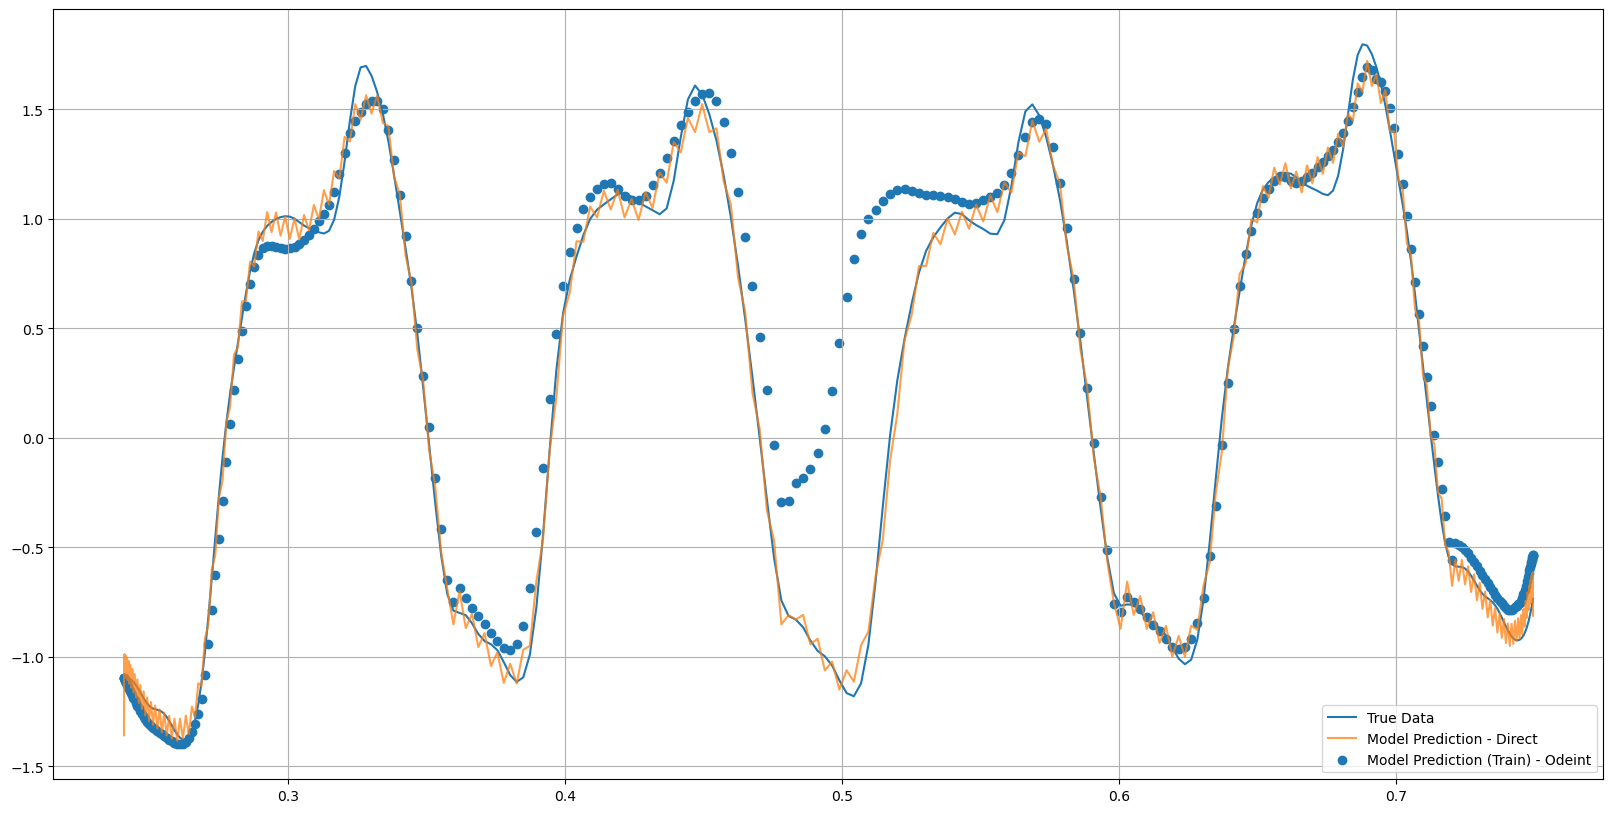

In [347]:
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)

plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(ts, y_pred, label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [348]:
import ode_solver_pyomo
importlib.reload(ode_solver_pyomo)
DirectODESolver = ode_solver_pyomo.DirectODESolver

trained_weights_biases = ode_model.extract_weights()

W1 = trained_weights_biases['W1']
b1 = trained_weights_biases['b1']
W2 = trained_weights_biases['W2']
b2 = trained_weights_biases['b2']

trained_weights = [W1, W2]
trained_biases = [b1, b2]

# Define the layer sizes as per your neural network architecture
layer_sizes = [W1.shape[1], W1.shape[0], W2.shape[0]]

tol = 1e-5
params = {"tol":1e-5, 
            "dual_inf_tol": tol, 
            "compl_inf_tol": tol,
            "constr_viol_tol": tol, 
            "acceptable_iter": 0,  
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 300 }

initial_state = (u_model[0])
# Initialize the direct ODE solver
direct_solver = DirectODESolver(np.array(ts), layer_sizes, trained_weights, trained_biases, initial_state, 
                                time_invariant=True, extra_input=np.array(Xs), params=params,
                                discretization_scheme = "BACKWARD")
# BACKWARD; LAGRANGE-LEGENDRE; 

# Build and solve the model
direct_solver.build_model()
solver_info = direct_solver.solve_model()

# Extract the solution
t_solution, y_solution = direct_solver.extract_solution()
print(len(y_solution))


Ipopt 3.14.16: tol=1e-05
dual_inf_tol=1e-05
compl_inf_tol=1e-05
constr_viol_tol=1e-05
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=300


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     1527
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      306

Total number of variables............................:      612
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
 

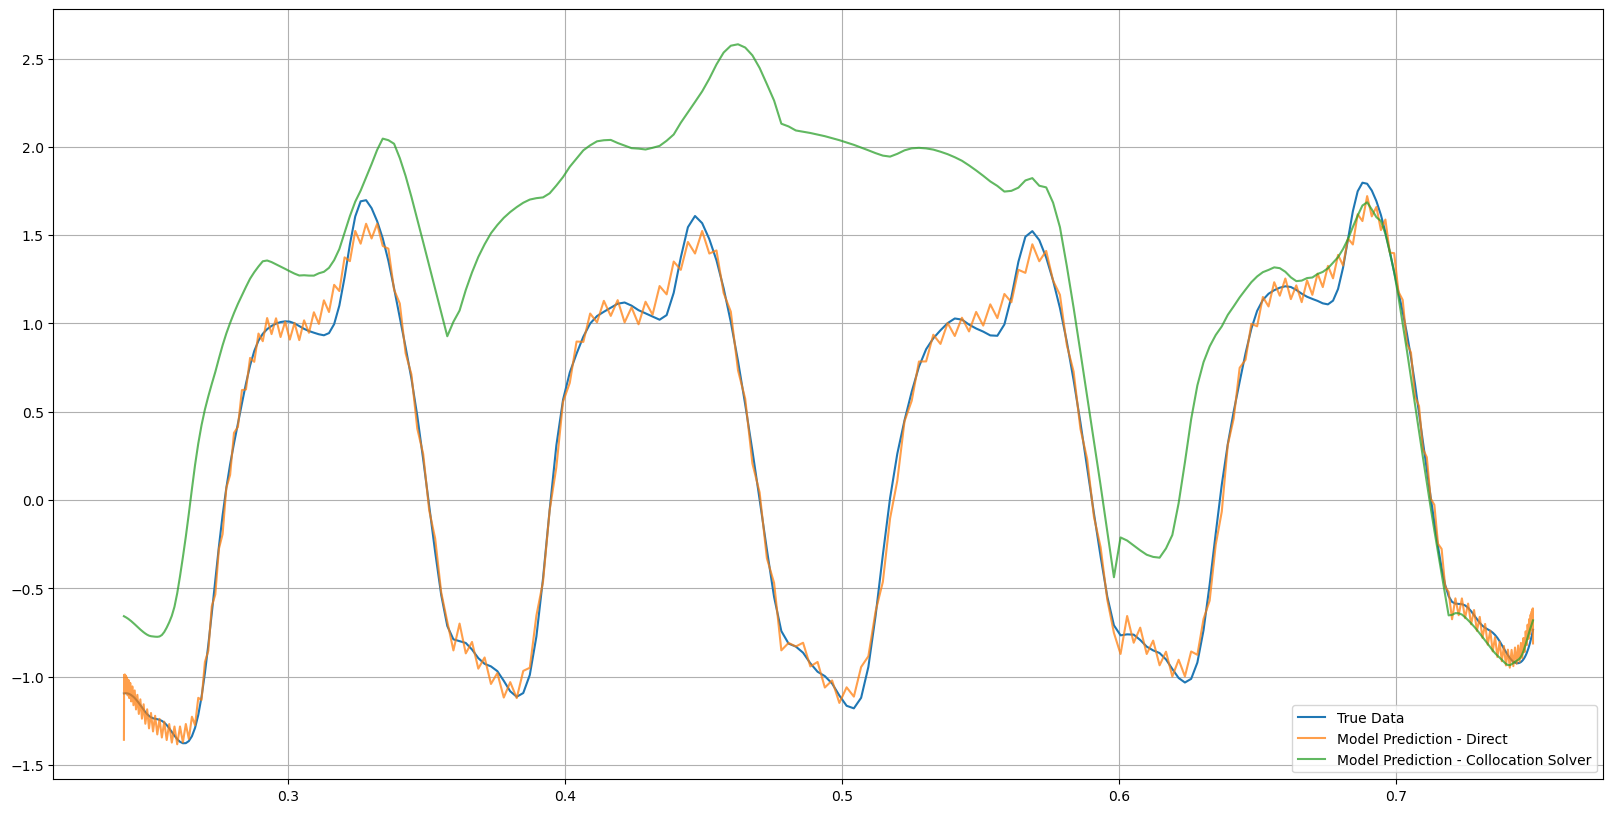

In [349]:
t_temp = np.linspace(min(ts), max(ts), len(y_solution))

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='True Data', alpha = 1)
plt.plot(ts, u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_solution, y_solution, label='Model Prediction - Collocation Solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

----